In [1]:
!pip3 install torch torchvision

  Using cached https://files.pythonhosted.org/packages/e0/50/8e78e6f62ffa50d6ca95c281d5a2819bef66d023ac1b723e253de5bda9c5/Pillow-7.1.2-cp36-cp36m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms  

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

In [5]:
def im_convert(tensor):  #.cpu() is because CUDA can not convert to numpy arrays
  image = tensor.cpu().clone().detach().numpy()  #creating a copy, detach any existing graphs etc, and convert to numpy
  image = image.transpose(1, 2, 0)  #(1, 28, 28) to (28, 28, 1)
  print(image.shape)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


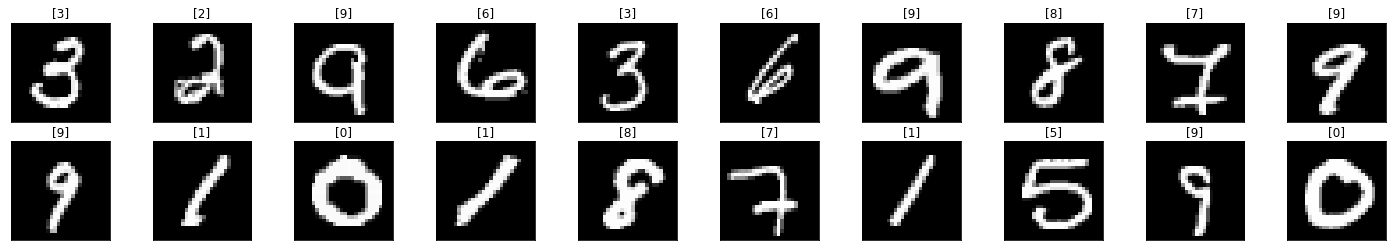

In [6]:
dataiter = iter(training_loader)  #iteration through a batch of images
images, labels = dataiter.next()  #next batch
fig = plt.figure(figsize = (25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  plt.imshow(im_convert(images[idx]))  #need to convert to np array to display
  ax.set_title([labels[idx].item()])

In [7]:
class LeNet(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 20, 5, 1)  #input depth, output depth, kernel size, strides
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(4 * 4 * 50, 500)  #ip, op size
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)


  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)  #ip, kernel size
    x = x.view(-1, 4 * 4 * 50)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x    #here we return the raw score , since we use nn.CrossEntropyLoss which is logsoftmax + Negative log likelihood - Value should not be close to 0 or 1 for log


In [8]:
model = LeNet().to(device)  #feed model used to GPU
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [10]:
# epochs = 15
# running_loss_history = []
# running_corrects_history = []
# val_running_loss_history = []
# val_running_corrects_history = []

# for e in range(epochs):
  
#   running_loss = 0.0
#   running_corrects = 0.0
#   val_running_loss = 0.0
#   val_running_corrects = 0.0
  
#   for inputs, labels in training_loader:
#     inputs = inputs.view(inputs.shape[0], -1)
#     outputs = model(inputs)
#     loss = criterion(outputs, labels)
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
#     _, preds = torch.max(outputs, 1)
#     running_loss += loss.item()
#     running_corrects += torch.sum(preds == labels.data)

#   else:
#     with torch.no_grad():
#       for val_inputs, val_labels in validation_loader:
#         val_inputs = val_inputs.view(val_inputs.shape[0], -1)
#         val_outputs = model(val_inputs)
#         val_loss = criterion(val_outputs, val_labels)
        
#         _, val_preds = torch.max(val_outputs, 1)
#         val_running_loss += val_loss.item()
#         val_running_corrects += torch.sum(val_preds == val_labels.data)
      
#     epoch_loss = running_loss/len(training_loader)
#     epoch_acc = running_corrects.float()/ len(training_loader)
#     running_loss_history.append(epoch_loss)
#     running_corrects_history.append(epoch_acc)
    
#     val_epoch_loss = val_running_loss/len(validation_loader)
#     val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
#     val_running_loss_history.append(val_epoch_loss)
#     val_running_corrects_history.append(val_epoch_acc)
#     print('epoch :', (e+1))
#     print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
#     print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

In [11]:
epochs = 12
running_loss_history = []
running_corrects_history = []
running_val_loss_history = []
running_val_corrects_history = []

for e in range(epochs):

  running_loss = 0.
  running_corrects = 0. 
  running_val_loss = 0.
  running_val_corrects = 0.

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)  #1st return value is the winning class score and preds is the winning class, stores in tensors for the data in current batch
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)   #the == returns in form [0, 1, 0, ...] where 1 is if the correct class is predicted, sum of all correct classes

  else:
      with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
          val_inputs = val_inputs.to(device)
          val_labels = val_labels.to(device)
          val_outputs = model(val_inputs)
          val_loss = criterion(val_outputs, val_labels)

          _, val_preds = torch.max(val_outputs, 1)
          running_val_loss += val_loss.item()
          running_val_corrects += torch.sum(val_preds == val_labels.data)

      val_epoch_loss = running_val_loss / len(validation_loader)
      val_epoch_acc = running_val_corrects.float() / len(validation_loader)
      running_val_loss_history.append(val_epoch_loss)
      running_val_corrects_history.append(val_epoch_acc)    

      epoch_loss = running_loss / len(training_loader)    #here also we can divide by len(training_loader.dataset)
      epoch_acc = running_corrects.float() / len(training_loader)   #Here we have taken the batch size as 100 so we get auto percentages, instead we can change the batch size and divide by len(training_dataset) as it will give us a probability of correctly classified images
      running_loss_history.append(epoch_loss)                          #Same applies to validation set
      running_corrects_history.append(epoch_acc)

      print("Epoch: {}".format(e))
      print("Training Loss : {:.4}, Acc : {:.4}".format(epoch_loss, epoch_acc.item()))
      print("Validation Loss : {:.4}, Acc : {:.4}".format(val_epoch_loss, val_epoch_acc.item()))

Epoch: 0
Training Loss : 0.5805, Acc : 84.27
Validation Loss : 0.1872, Acc : 94.54
Epoch: 1
Training Loss : 0.1467, Acc : 95.65
Validation Loss : 0.1013, Acc : 96.95
Epoch: 2
Training Loss : 0.09723, Acc : 97.14
Validation Loss : 0.07617, Acc : 97.79
Epoch: 3
Training Loss : 0.07658, Acc : 97.69
Validation Loss : 0.06267, Acc : 98.11
Epoch: 4
Training Loss : 0.06322, Acc : 98.13
Validation Loss : 0.05511, Acc : 98.15
Epoch: 5
Training Loss : 0.0554, Acc : 98.37
Validation Loss : 0.04886, Acc : 98.49
Epoch: 6
Training Loss : 0.0486, Acc : 98.58
Validation Loss : 0.04158, Acc : 98.53
Epoch: 7
Training Loss : 0.04401, Acc : 98.66
Validation Loss : 0.04031, Acc : 98.75
Epoch: 8
Training Loss : 0.03916, Acc : 98.87
Validation Loss : 0.03683, Acc : 98.77
Epoch: 9
Training Loss : 0.03584, Acc : 98.88
Validation Loss : 0.03601, Acc : 98.83
Epoch: 10
Training Loss : 0.03265, Acc : 99.01
Validation Loss : 0.0369, Acc : 98.88
Epoch: 11
Training Loss : 0.03061, Acc : 99.09
Validation Loss : 0.0298

In [12]:
# epochs = 12
# running_loss_history = []
# running_corrects_history = []

# for e in range(epochs):

#   running_loss = 0.
#   running_corrects = 0. 

#   for inputs, labels in training_loader:
#     inputs = inputs.view(inputs.shape[0], -1)
#     outputs = model(inputs)
#     loss = criterion(outputs, labels)

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     _, preds = torch.max(outputs, 1)  #1st return value is the winning class score and preds is the winning class, stores in tensors for the data in current batch
#     running_loss += loss.item()
#     running_corrects += torch.sum(preds == labels.data)   #the == returns in form [0, 1, 0, ...] where 1 is if the correct class is predicted, sum of all correct classes

#   else:
#       epoch_loss = running_loss / len(training_loader)
#       epoch_acc = running_corrects.float() / len(training_loader)
#       running_loss_history.append(epoch_loss)
#       running_corrects_history.append(epoch_acc)
#       print("Training Loss : {:.4}, Acc : {:.4}".format(epoch_loss, epoch_acc.item()))

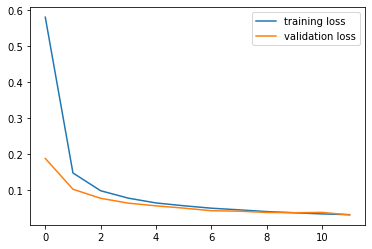

In [13]:
plt.plot(running_loss_history, label = 'training loss')
plt.plot(running_val_loss_history, label = 'validation loss')
plt.legend()

#Dropout helps to reduce the generalization error and hence reduces overfitting

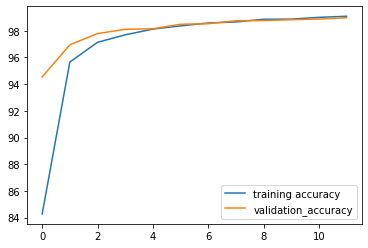

In [14]:
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(running_val_corrects_history, label = 'validation_accuracy')
plt.legend()

In [ ]:
!pip3 install pillow==4.0.0

In [16]:
import PIL.ImageOps

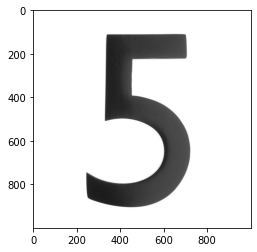

In [17]:
import requests
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

(28, 28, 1)


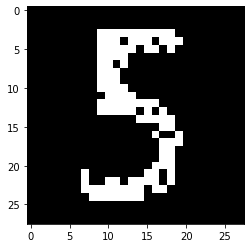

In [18]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')  #to BW 1 channel mode
img = transform(img)  #resizing etc
plt.imshow(im_convert(img))

In [26]:
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)  #Convert it to 4dims as needed by conv NW
output = model(image)   
_, pred = torch.max(output, 1)
print(pred.item())

5


(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


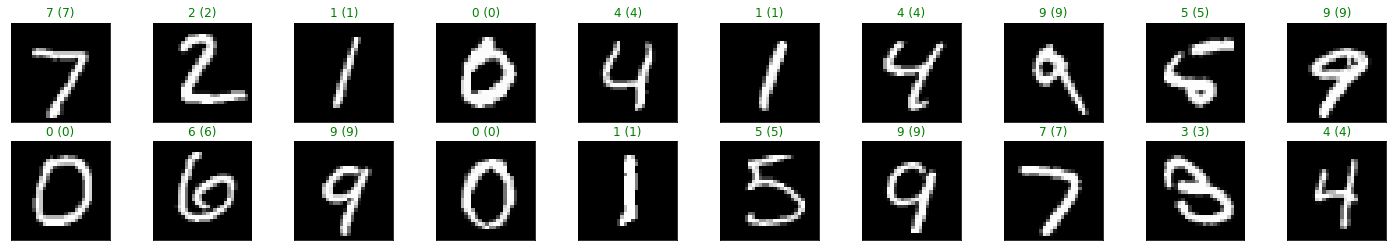

In [28]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images_ = images.to(device)  #no need to unsqueeze as we are passing in batches that will take care of extra dims
labels = labels.to(device)
outputs = model(images_)
_, preds = torch.max(outputs, 1)

fig = plt.figure(figsize = (25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color = ("green" if preds[idx] == labels[idx] else "red"))
